In [247]:

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Attention, Input,LSTM, Bidirectional, Dense, Embedding, Concatenate, TimeDistributed
from tensorflow.keras.models import Model, save_model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
# import warnings
# warnings.filterwarnings("ignore")

In [322]:
df = pd.read_csv("data/reviews.csv")

In [323]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [324]:
df.shape

(568454, 10)

In [325]:
df.isna().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [326]:
df.dropna(axis=0, inplace=True)
df.isna().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

In [327]:
df = df.sample(frac =0.05, random_state=42)
df.shape

(28420, 10)

In [328]:
#contraction map dict
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [329]:
#stopwords
stop_words = set(stopwords.words("english"))

def preprocess(text):
  #lower case
  text = text.lower()
  # remove tags
  #text = BeautifulSoup(text, "lxml").text
  #remove text inside parenthesis
  text = re.sub(r'\([^)]*\)',"",text)
  #remove double quotes
  text = re.sub('"', '', text)
  #eliminate punctuations and special characters
  text = re.sub("[^a-zA-Z]", " ", text)
  #contraction mapping
  text = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in text.split(" ")])
  #remove 's
  text = re.sub(r"'s\b","", text)
  #remove stopwords 
  words = [w for w in text.split() if w not in stop_words]
  #removing short words
  long_words = []
  for i in words:
    if len(i)>1:
      long_words.append(i)
  text = (" ".join(long_words)).strip()
  return text

In [330]:
df['processed_text'] = df['Text'].apply(lambda x: preprocess(x))
df['processed_text']

18828     avocado oil beats olive oil dressings anything...
363857    new years resolution season bought protein plu...
342609    pretty sad got peaches stated china china real...
62213     find people north america brew tea long period...
467133    love recycled works well store bought product ...
                                ...                        
508075    good reviewers taste buds weak disappointingly...
381707    discovered popcorn oil local store find anymor...
268235    nature path crunchy vanilla sunrise might warm...
182524    first name like vanilla blueberry clusters thi...
4352      gluten free hard especially dorm gotten really...
Name: processed_text, Length: 28420, dtype: object

In [331]:
df['processed_summary'] = df['Summary'].apply(lambda x: preprocess(x))
df['processed_summary']

18828                avocado oil
363857        healthy tastes oky
342609             peaches china
62213      perhaps brewing wrong
467133               works great
                   ...          
508075      either got bad batch
381707     best popcorn oil ever
268235      flavorful full sugar
182524    blueberry otherwise ok
4352         practical yumminess
Name: processed_summary, Length: 28420, dtype: object

In [332]:
df["processed_summary"] = df["processed_summary"].apply(lambda x: 'sos '+ x + ' eos')
df["processed_summary"]

18828                sos avocado oil eos
363857        sos healthy tastes oky eos
342609             sos peaches china eos
62213      sos perhaps brewing wrong eos
467133               sos works great eos
                       ...              
508075      sos either got bad batch eos
381707     sos best popcorn oil ever eos
268235      sos flavorful full sugar eos
182524    sos blueberry otherwise ok eos
4352         sos practical yumminess eos
Name: processed_summary, Length: 28420, dtype: object

In [333]:
text_count = []
summary_count = []
for i in df['processed_text']:
  text_count.append(len(i.split()))
  
for i in df['processed_summary']:
  summary_count.append(len(i.split()))


<Axes: ylabel='Count'>

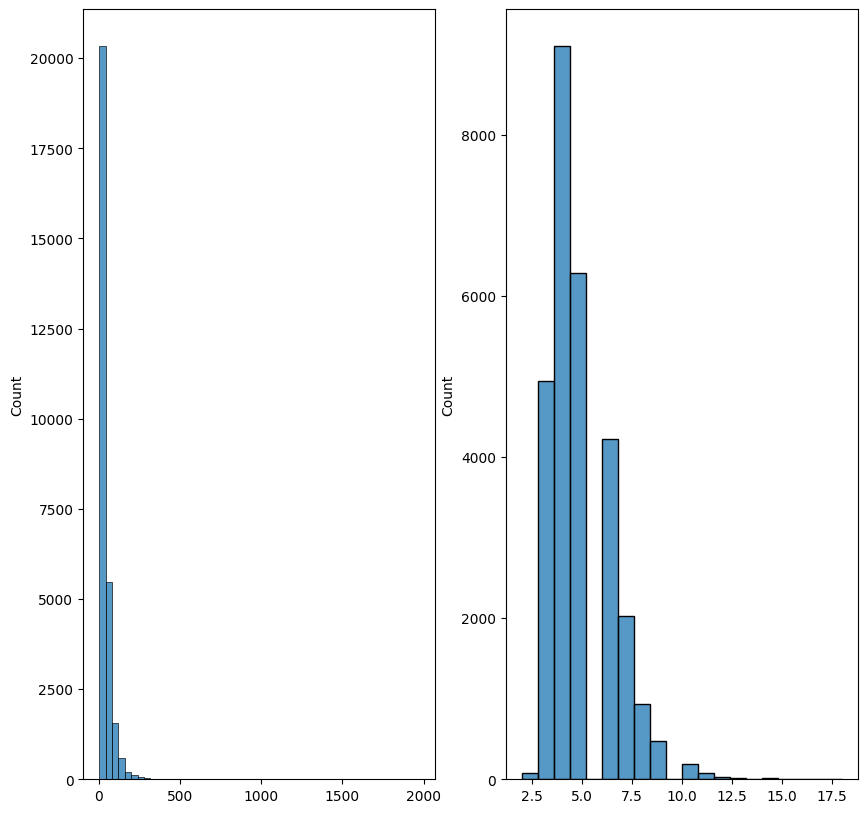

In [334]:
plt.figure(figsize=(10,10))
plt.subplot(121)
sns.histplot(text_count,bins=50)
plt.subplot(122)
sns.histplot(summary_count,bins=20)

In [335]:
max_text_len = 30
max_summary_len =13

In [336]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.array(df['processed_text']), np.array(df["processed_summary"]), test_size=0.3, random_state=42, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_test,y_test ,test_size=0.2, random_state=42, shuffle=True)



In [337]:
X_train

array(['israeli couscous developed austerity period israel rice scarce combination seminola wheat flour israeli couscous small round pasta like granules twice big toasted rather dried gives nutty flavor sturdy composition gives chewy bite makes stand sauce br br israeli couscous become real favorite house easy prepare mixed many food items br israeli couscous like entirely different food plumps luscious individual pearls pop mouth much different regular couscous prepared treat familiar wanting try buy israeli couscous amazon br br like use chicken vegetable broth israeli couscous gives couscous almost creamy hefty base mix pine nuts parsley whatever herbs like best couscous luscious takes place grains pastas br br highly recommended prisrob',
       'dog fairly sensitive stomach picky eater usually quite careful trying new treats loved href http www amazon com gp product zjhw zuke chicken flavored mini naturals dog treats ounces thought might well give hip action try loved br also grea

In [338]:
X_tokenizer = Tokenizer(oov_token="<oov>")
X_tokenizer.fit_on_texts(X_train)
total_X_train = len(X_tokenizer.word_index)


In [339]:
X_tokenizer = Tokenizer(oov_token="<oov>", num_words=total_X_train)
X_tokenizer.fit_on_texts(X_train)

#text to sequence
X_train_seq = X_tokenizer.texts_to_sequences(X_train)
X_test_seq = X_tokenizer.texts_to_sequences(X_test)
X_val_seq = X_tokenizer.texts_to_sequences(X_val)

#pad sequence
X_train = pad_sequences(X_train_seq, maxlen=max_text_len, padding='post')
X_test = pad_sequences(X_test_seq, maxlen=max_text_len, padding='post')
X_val = pad_sequences(X_val_seq, maxlen=max_text_len, padding='post')




In [340]:
x_voc   =  X_tokenizer.num_words + 1
x_voc

26079

In [341]:
y_tokenizer = Tokenizer(oov_token="<oov>")
y_tokenizer.fit_on_texts(y_train)
total_y_train = len(y_tokenizer.word_index)

In [342]:
y_tokenizer = Tokenizer(oov_token="<oov>", num_words=total_y_train)
y_tokenizer.fit_on_texts(y_train)

#text to sequence
y_train_seq = y_tokenizer.texts_to_sequences(y_train)
y_test_seq = y_tokenizer.texts_to_sequences(y_test)
y_val_seq = y_tokenizer.texts_to_sequences(y_val)

#pad sequence
y_train = pad_sequences(y_train_seq, maxlen=max_summary_len, padding='post')
y_test = pad_sequences(y_test_seq, maxlen=max_summary_len, padding='post')
y_val = pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

y_voc   =  y_tokenizer.num_words + 1
y_voc

6976

In [343]:
X_train.shape

(19894, 30)

In [344]:
latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# # Attention layer
# attn_layer = Attention()
# attn_out = attn_layer([encoder_outputs, decoder_outputs])

# # Concat attention input and decoder LSTM output
# decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_40      │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_35        │ (None, 30, 100)   │  2,607,900 │ input_layer_40[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_69 (LSTM)      │ [(None, 30, 300), │    481,200 │ embedding_35[0][… │
│                     │ (None, 300),      │            │                   │
│                     │ (None, 300)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_41      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_70 (LSTM)      │ [(None, 30, 300), │    721,200 │ lstm_69[0][0]     │
│                     │ (None, 300),      │            │                   │
│                     │ (None, 300)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_36        │ (None, None, 100) │    697,600 │ input_layer_41[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_71 (LSTM)      │ [(None, 30, 300), │    721,200 │ lstm_70[0][0]     │
│                     │ (None, 300),      │            │                   │
│                     │ (None, 300)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_72 (LSTM)      │ [(None, None,     │    481,200 │ embedding_36[0][… │
│                     │ 300), (None,      │            │ lstm_71[0][1],    │
│                     │ 300), (None,      │            │ lstm_71[0][2]     │
│                     │ 300)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_12 │ (None, None,      │  2,099,776 │ lstm_72[0][0]     │
│ (TimeDistributed)   │ 6976)             │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,810,076 (29.79 MB)

 Trainable params: 7,810,076 (29.79 MB)

 Non-trainable params: 0 (0.00 B)

In [345]:
optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy')

In [346]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [347]:
X_train.shape

(19894, 30)

In [348]:
y_train[:,:-1].shape

(19894, 12)

In [350]:
history = model.fit([X_train,y_train[:,:-1]],y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:,1:], epochs=10,
                  callbacks=[es],
                  batch_size=128, 
                  validation_data=([X_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:,1:])
                 )

Epoch 1/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 605s 4s/step - loss: 1.9637 - val_loss: 1.7225
Epoch 2/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 350s 2s/step - loss: 1.6733 - val_loss: 1.6900
Epoch 3/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 381s 2s/step - loss: 1.5600 - val_loss: 1.6934
Epoch 4/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 433s 3s/step - loss: 1.4727 - val_loss: 1.7030
Epoch 4: early stopping


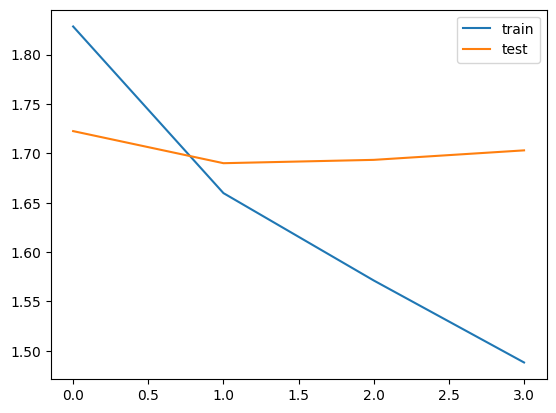

In [353]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [351]:
target_backtoword = y_tokenizer.index_word
target_index = y_tokenizer.word_index
input_backtoword = X_tokenizer.index_word


In [352]:
#inference model
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])
#decoder
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
dec_emb2= dec_emb_layer(decoder_inputs)
decoder_outputs, state_h, state_c = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [390]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    # print(e_out)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_index['sos']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [ e_h, e_c])
        # print(output_tokens)
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = target_backtoword[sampled_token_index]
        
        if(sampled_token!='eos'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eos'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [355]:
def seq2text(seq):
    text=''
    for i in seq:
        if(i!=0):
            text=text+input_backtoword[i]+' '
    return text
  
def seq2summary(seq):
    text=''
    for i in seq:
        if((i!=0 and i!=target_index['sos']) and i!=target_index['eos']):
            text=text+target_backtoword[i]+' '
    return text

In [382]:
X_train[10].reshape(1,max_text_len)

array([[ 1328,    20,   347,  3582,    29,    30, 11858,  3059,  2882,
           99,   899,   345,  2293,  1274,   781,    10,   430,  7829,
            7,    23,     6,   983,     0,     0,     0,     0,     0,
            0,     0,     0]], dtype=int32)

In [389]:
#try inference
print("Review:",seq2text(X_train[10]))
print("Original summary:",seq2summary(y_train[10]))
print("Predicted summary:",decode_sequence(X_train[10].reshape(1,max_text_len)))

Review: fabulous little red pearls even better craisins plump juicy perfect banana bread semi tart cherry flavor body definitive taste buy great surprise 
Original summary: yum 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
[[[ 1.92606360e-01  2.28737578e-01 -1.26782760e-01 ... -3.21145892e-01
    1.74253248e-02  1.36047201e-02]
  [ 4.86355275e-02  6.65939786e-03 -1.34807022e-03 ...  2.52916038e-01
   -7.79429800e-04  5.38959960e-03]
  [ 1.69901289e-02 -2.33325977e-02  5.01778632e-05 ...  3.38369608e-02
   -4.60503623e-04  1.10740645e-03]
  ...
  [-5.10950413e-05 -4.03508893e-05  1.82076647e-07 ...  8.08953973e-06
   -3.15711901e-07  1.30120078e-02]
  [-4.89704107e-05 -4.10444882e-05  1.71565830e-07 ...  7.90003287e-06
   -2.39557039e-07  1.38346255e-02]
  [-4.82225223e-05 -4.35034926e-05  1.97893527e-07 ...  9.04236640e-06
   -2.51502058e-07  1.35371983e-02]]]


/Users/akshayshendre/Desktop/textSummerization/summ-venv/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_309', 'keras_tensor_315', 'keras_tensor_316']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step
[[[3.3122278e-04 3.4108180e-06 5.9391141e-07 ... 3.2588553e-06
   2.0841442e-06 5.8219143e-07]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
[[[5.9172289e-05 1.8727091e-05 1.5464067e-07 ... 2.9994392e-06
   5.9022850e-06 1.6087954e-07]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
[[[3.0858754e-04 6.9549458e-08 5.6388760e-08 ... 2.5380873e-06
   1.2674181e-07 4.7175000e-08]]]
Predicted summary:  great product
